## Library Imports

In [1]:
# Just need once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Project05
# %cd drive/MyDrive/'5. Sign Language'/Project05

/content/drive/.shortcut-targets-by-id/1FOk_Lk6NLWAynAk-_uIaI0eDfwMGhJlM/Project05


In [3]:
# double check you are in the Project05 folder
! pwd

/content/drive/.shortcut-targets-by-id/1FOk_Lk6NLWAynAk-_uIaI0eDfwMGhJlM/Project05


In [4]:
import copy
import importlib
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import time
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Subset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
print(torch.__version__)

print("Imported")

1.13.0+cu116
Imported


In [ ]:
# !ls
# %cd tiny-cuda-nn/
# !cmake . -B build
# !cmake --build build --config RelWithDebInfo -j
# %cd ..

In [5]:
import tinynas.nn.networks.mobilenet_v2
importlib.reload(tinynas.nn.networks.mobilenet_v2)
from tinynas.nn.networks.mobilenet_v2 import MobileNetV2, ProxylessNASNets
from tinynas.nn.modules.layers import LinearLayer

print("Imported")


Imported


In [6]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# run this once, obtain your own kaggle username and API key
import json

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token =  {"username":"dash102",
             "key":"bb76443de4a0739e95507bcf69e0fed8"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
# ! kaggle datasets download grassknoted/asl-alphabet --unzip

### Load and Build network via config

In [8]:
#loading the model and initializing it with saved weights
file = open('assets/configs/mcunet-5fps_imagenet.json')
config = json.load(file)
model = ProxylessNASNets.build_from_config(config)
#checkpoint = torch.load('assets/pt_ckpt/mcunet-5fps_imagenet.pth')
#model.load_state_dict(checkpoint['state_dict'])

In [9]:
model.classifier.config

{'name': 'LinearLayer',
 'in_features': 160,
 'out_features': 1000,
 'bias': True,
 'use_bn': False,
 'act_func': None,
 'dropout_rate': 0,
 'ops_order': 'weight_bn_act'}

### Preparing network for finetuning

In [10]:
def prepare_net_for_finetune(net, num_classes_new_dataset):
    #freeze_layers_for_finetune(net.__class__.__name__, net)
    existing_classifier_config = net.classifier.config
    del(existing_classifier_config['name'])
    existing_classifier_config['out_features'] = num_classes_new_dataset
    existing_classifier_config['dropout_rate'] = 0.5
    net.classifier = LinearLayer.build_from_config(existing_classifier_config)
    return net

def freeze_layers_for_finetune(name, net):
    if isinstance(net, torch.nn.Module):
        if net._modules:
            for layer_name, layer in net._modules.items():
                aggregate_name = ".".join([name, layer_name])
                freeze_layers_for_finetune(aggregate_name, layer)
        else:
            if "classifier" not in name:		# Freeze all layers except last classifier
                for p in net.parameters():
                    p.requires_grad = False
                    
net = prepare_net_for_finetune(model, 29)    ## Change Classification layer to have 29 outputs with dropout rate of 0.5, lock all other layer weights

In [11]:
for m in net.classifier._modules.values():
    print(type(m))

<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.linear.Linear'>


### Load dataset

In [12]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [13]:
from torch.utils.data import Dataset, TensorDataset,DataLoader, ConcatDataset

In [14]:
#load in data
def return_data_loader(data_dirs, batch_size, phase, resolution):
    # data_dirs = ['dir1', 'dir2', ...]
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((resolution, resolution)),
            #transforms.RandomRotation(degrees=(0, 15)),
            transforms.RandomHorizontalFlip(),
            #transforms.RandomAdjustSharpness(sharpness_factor=2),
            #transforms.RandomAutocontrast(0.7),
            transforms.ColorJitter(brightness=0.3, saturation=0.3, hue=0.1),
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    
        'test': transforms.Compose([
            transforms.Resize((resolution,resolution)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    }
    # beforehand: split new data into train/ val/ test/ folders once, then use every time you train

    original_data = ImageFolderWithPaths(os.path.join(data_dirs[0], phase), transform = data_transforms[phase])

    # for i in range(1, len(data_dirs)):
    additional_data = ImageFolderWithPaths(os.path.join(data_dirs[1], phase), transform = data_transforms[phase])

    # data = ImageFolderWithPaths('/content/drive/MyDrive/Project05/new_datasets/ASL_Dataset/train')

    final_data = ConcatDataset([original_data, additional_data])

  
  

    if phase == 'train':
        train_loader = torch.utils.data.DataLoader(final_data, batch_size=batch_size, shuffle=True, drop_last=True,
                                                num_workers=4)
        # train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True,
        #                                         num_workers=4)
        
        return train_loader
    
    elif phase == "val":
        val_loader = torch.utils.data.DataLoader(final_data, batch_size=batch_size, shuffle=False, drop_last=False,
                                        num_workers=4)
        return val_loader
    
    else: 
        test_loader = torch.utils.data.DataLoader(final_data, batch_size=batch_size, shuffle=False, drop_last=False,
                                                    num_workers=4)
        return test_loader

In [15]:
# testing new data 
import tensorflow as tf 
import os
import cv2
import imghdr


data_dir ='/content/drive/MyDrive/Project05/new_datasets/ASL_Dataset/train'
image_exts=['jpeg','jpg','bmp','png']
image_exts[2]


'bmp'

In [ ]:
# for image_class in os.listdir(data_dir): 
#     for image in os.listdir(os.path.join(data_dir, image_class)):
#         image_path = os.path.join(data_dir, image_class, image)
#         try: 
#             img = cv2.imread(image_path)
#             tip = imghdr.what(image_path)
#             if tip not in image_exts: 
#                 print('Image not in ext list {}'.format(image_path))
#                 os.remove(image_path)
#         except Exception as e: 
#             print('Issue with image {}'.format(image_path))

In [ ]:
# # tried to upload the new data and show pics
# import numpy as np
# from matplotlib import pyplot as plt
# import tensorflow as tf
# data = tf.keras.utils.image_dataset_from_directory('new_datasets')

In [ ]:
# data_iterator = data.as_numpy_iterator()

In [ ]:
# batch = data_iterator.next()

In [ ]:
# fig, ax = plt.subplots(ncols=4, figsize=(15,20))
# for idx, img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img.astype(int))
#     ax[idx].title.set_text(batch[1][idx])

In [ ]:
# Scale the data
# data = data.map(lambda x,y: (x/255, y))
# data.as_numpy_iterator().next()

In [ ]:
# train_size = int(len(data)*.7)
# val_size = int(len(data)*.2)
# test_size = int(len(data)*.1)
# train_size

In [ ]:
# train = data.take(train_size)
# val = data.skip(train_size).take(val_size)
# test = data.skip(train_size+val_size).take(test_size)

In [ ]:
#import cv2
#img = cv2.imread('a.jpg')
#plt.imshow(img)
#plt.show()

In [16]:
#loading data
all_data_dirs = ['./splitted_data', 'new_datasets/ASL_Dataset'] #can change the splitted data
# target_data_dir = "./"   ## May need to change it to the path where you have ASL stored after running process_asl_dataset.py
train_loader = return_data_loader(all_data_dirs, 256, phase = 'train', resolution=96)
val_loader = return_data_loader(all_data_dirs, 256, phase = 'val', resolution=96)

# print("Class Label to Network Output Index {}".format(train_loader.dataset.class_to_idx))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# loader_iter = iter(train_loader)

In [ ]:
# batch = next(loader_iter)[0]

In [ ]:
# f, ax = plt.subplots(1, 4, figsize=(20, 5))

# for i, data in enumerate(batch):
#   ax[i].imshow(data.permute(0, 2, 0))

### Train Model

In [17]:
from tqdm import tqdm

In [18]:
train_losses = []
val_losses = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs, writer, weights_dir):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        start_epoch = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(total=len(dataloaders[phase]), position=0, leave=True) as pbar:
              for data in tqdm(dataloaders[phase], position=0, leave=True):
                  inputs, labels, paths = data
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward + track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)
                      if phase == 'train':
                          train_losses.append(loss.item())
                      elif phase == 'val':
                          val_losses.append(loss.item())

                      _, preds = torch.max(outputs, 1)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
                  pbar.update()
            plt.plot(train_losses)
            plt.show()
            
            #printing and writing to tensorboard loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            writer.add_scalar(phase + ' loss', epoch_loss, epoch)
            writer.add_scalar(phase + ' accuracy', epoch_acc, epoch)
            
            #printing time per epoch
            time_elapsed_epoch = time.time() - start_epoch
            print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed_epoch // 60, time_elapsed_epoch % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
                #save model weights to best weights_dir
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': criterion,
                    }, weights_dir + "best_weights/model_" + str(epoch + 1) + ".pth")
            if phase == 'val':
                #save model weights after every epoch
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': criterion,
                    }, weights_dir + "model_" + str(epoch + 1) + ".pth")
                

        print()
        
    writer.flush()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
#creating optimizer
optimizer_ft = torch.optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.001) #weight_decay = 0.00004)

#setting loss function
criterion = torch.nn.CrossEntropyLoss()

#detecting if there's a gpu available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)

In [20]:
#setting up tensorboard
# ! mkdir logs/
writer = SummaryWriter('logs/gianna_test_run')

Epoch 0/39
----------


100%|██████████| 261/261 [1:45:42<00:00, 24.30s/it]


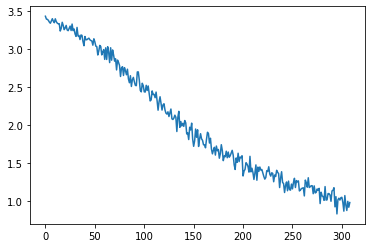

train Loss: 1.7967 Acc: 0.4326
Epoch complete in 105m 42s


100%|██████████| 79/79 [39:44<00:00, 30.18s/it]


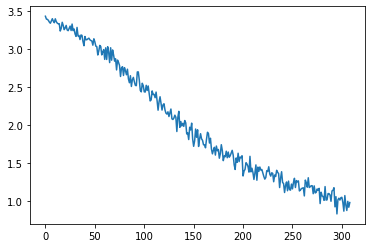

val Loss: 1.0252 Acc: 0.6595
Epoch complete in 145m 27s

Epoch 1/39
----------


100%|██████████| 261/261 [14:36<00:00,  3.36s/it]


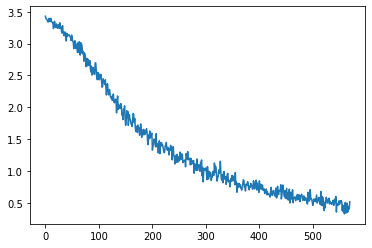

train Loss: 0.6688 Acc: 0.7753
Epoch complete in 14m 37s


100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


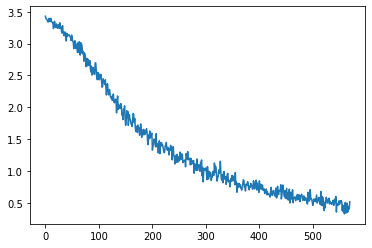

val Loss: 0.5450 Acc: 0.8296
Epoch complete in 16m 43s

Epoch 2/39
----------


100%|██████████| 261/261 [13:12<00:00,  3.03s/it]


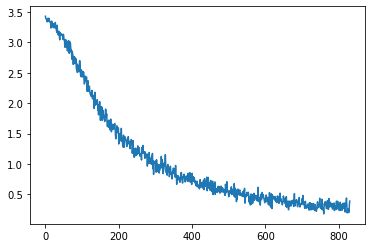

train Loss: 0.3541 Acc: 0.8845
Epoch complete in 13m 12s


100%|██████████| 79/79 [02:10<00:00,  1.65s/it]


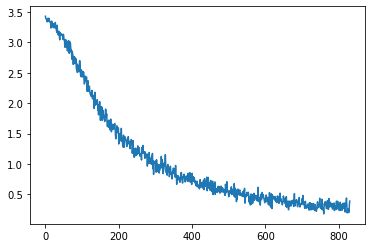

val Loss: 0.3508 Acc: 0.8949
Epoch complete in 15m 23s

Epoch 3/39
----------


100%|██████████| 261/261 [13:21<00:00,  3.07s/it]


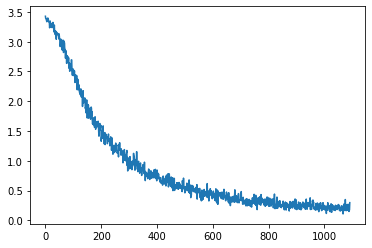

train Loss: 0.2304 Acc: 0.9268
Epoch complete in 13m 21s


100%|██████████| 79/79 [02:08<00:00,  1.63s/it]


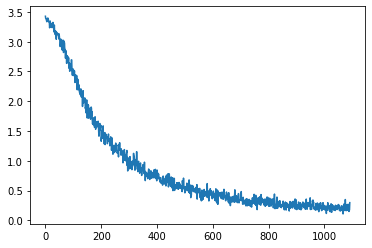

val Loss: 0.2794 Acc: 0.9112
Epoch complete in 15m 30s

Epoch 4/39
----------


100%|██████████| 261/261 [13:12<00:00,  3.04s/it]


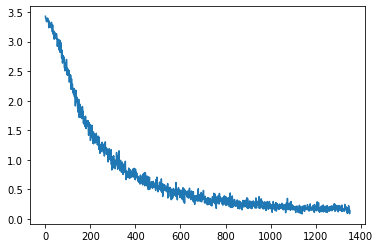

train Loss: 0.1753 Acc: 0.9458
Epoch complete in 13m 13s


100%|██████████| 79/79 [02:12<00:00,  1.67s/it]


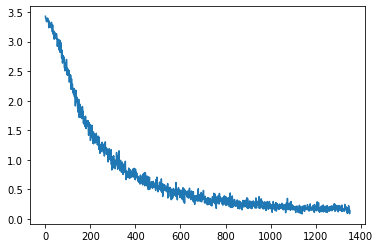

val Loss: 0.2259 Acc: 0.9301
Epoch complete in 15m 25s

Epoch 5/39
----------


100%|██████████| 261/261 [14:07<00:00,  3.25s/it]


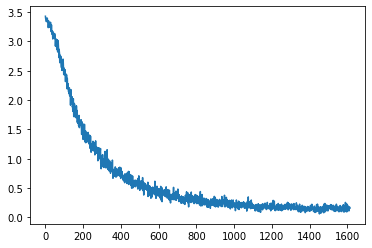

train Loss: 0.1507 Acc: 0.9536
Epoch complete in 14m 8s


100%|██████████| 79/79 [02:09<00:00,  1.64s/it]


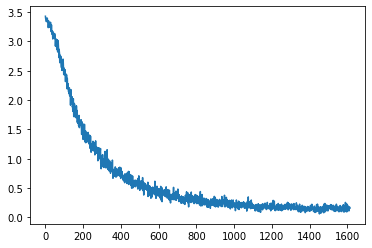

val Loss: 0.2335 Acc: 0.9276
Epoch complete in 16m 18s

Epoch 6/39
----------


100%|██████████| 261/261 [13:47<00:00,  3.17s/it]


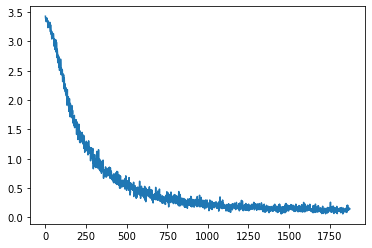

train Loss: 0.1286 Acc: 0.9603
Epoch complete in 13m 48s


100%|██████████| 79/79 [02:10<00:00,  1.66s/it]


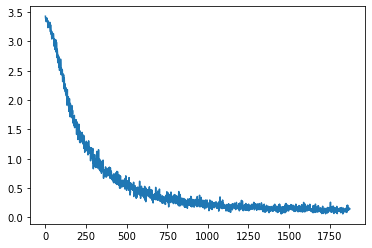

val Loss: 0.1654 Acc: 0.9502
Epoch complete in 15m 59s

Epoch 7/39
----------


100%|██████████| 261/261 [14:05<00:00,  3.24s/it]


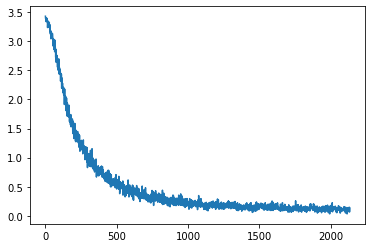

train Loss: 0.1125 Acc: 0.9661
Epoch complete in 14m 6s


100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


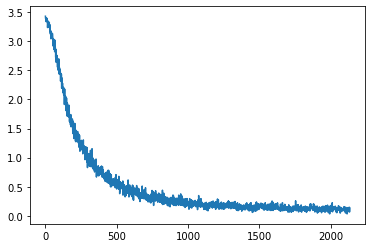

val Loss: 0.1675 Acc: 0.9505
Epoch complete in 16m 12s

Epoch 8/39
----------


100%|██████████| 261/261 [13:53<00:00,  3.19s/it]


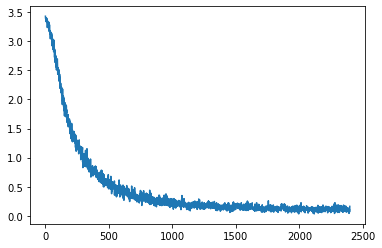

train Loss: 0.1099 Acc: 0.9674
Epoch complete in 13m 54s


100%|██████████| 79/79 [02:08<00:00,  1.62s/it]


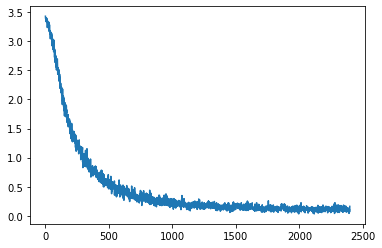

val Loss: 0.1552 Acc: 0.9536
Epoch complete in 16m 2s

Epoch 9/39
----------


100%|██████████| 261/261 [14:04<00:00,  3.23s/it]


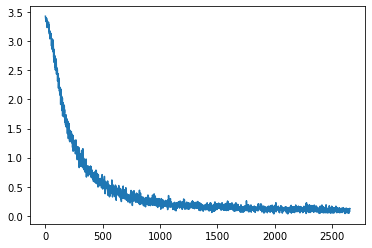

train Loss: 0.0969 Acc: 0.9710
Epoch complete in 14m 4s


100%|██████████| 79/79 [02:12<00:00,  1.67s/it]


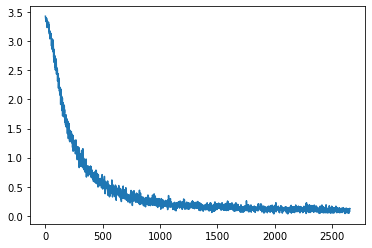

val Loss: 0.1552 Acc: 0.9557
Epoch complete in 16m 17s

Epoch 10/39
----------


100%|██████████| 261/261 [13:52<00:00,  3.19s/it]


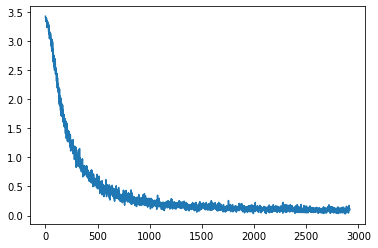

train Loss: 0.0908 Acc: 0.9728
Epoch complete in 13m 52s


100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


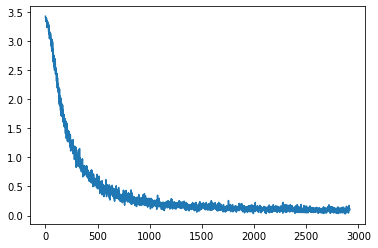

val Loss: 0.1266 Acc: 0.9630
Epoch complete in 15m 59s

Epoch 11/39
----------


100%|██████████| 261/261 [13:41<00:00,  3.15s/it]


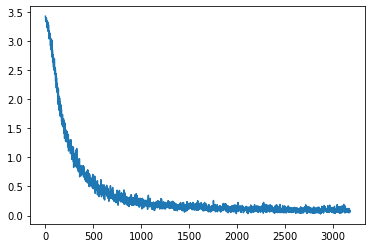

train Loss: 0.0916 Acc: 0.9725
Epoch complete in 13m 42s


100%|██████████| 79/79 [02:06<00:00,  1.60s/it]


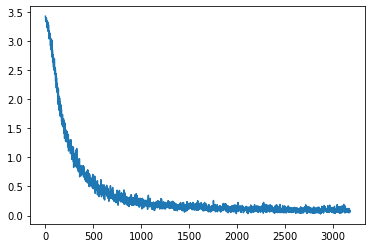

val Loss: 0.1191 Acc: 0.9666
Epoch complete in 15m 48s

Epoch 12/39
----------


 61%|██████▏   | 160/261 [08:36<05:13,  3.10s/it]

In [ ]:
#training and evaluating on validation dataset
dataloaders_dict = {"train": train_loader, "val": val_loader}
#dataloaders_dict = {"train": train_loader}
weights_dir = "logs/experiment_1/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)
    os.mkdir(weights_dir + "/best_weights")
model_ft = train_model(net, dataloaders_dict, criterion, optimizer_ft, 40, writer, weights_dir)


## Testing the fine tuned model

In [21]:
def test_model(model, test_loader):
    model.eval()
    
    correct = 0
    total = 0
    all_preds = torch.tensor([])
    all_preds = all_preds.to(device)
    all_labels = torch.tensor([])
    all_labels = all_labels.to(device)
    all_paths = []
    
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels, paths = data
            
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(inputs)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds = torch.cat(
                (all_preds, predicted)
                ,dim=0
            )

            all_labels = torch.cat(
                (all_labels, labels)
                ,dim=0
            )
            
            all_paths = all_paths + list(paths)
            
    acc = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (acc))
    return acc, all_preds, all_labels, all_paths

In [24]:
#loading the model for testing and initializing it with the best weights
file = open('assets/configs/mcunet-5fps_imagenet.json')
# file = open('new_datasets/ASL_Dataset/test'
config = json.load(file)
model = ProxylessNASNets.build_from_config(config)
model_ft = prepare_net_for_finetune(model, 29)

## Go to the weights folder and check the best weights checkpoint (add it here)
checkpoint = torch.load('logs/experiment_1/best_weights/model_1.pth')
model_ft.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
## Test loader and testing
print(all_data_dirs)
test_loader = return_data_loader(all_data_dirs[1], 20, phase = 'test', resolution=96)
acc, all_preds, all_labels, all_paths = test_model(model_ft, test_loader)

['./splitted_data', 'new_datasets/ASL_Dataset']


FileNotFoundError: ignored

### Confusion Matrix

In [ ]:
#confusion matrix for har_up and montreal dataset
from sklearn.metrics import confusion_matrix
import seaborn

y_preds = all_preds.cpu().data.numpy()
y_labels = all_labels.cpu().data.numpy()

#print(len(class_names))
#labels = ['empty', 'full']
labels = train_loader.dataset.class_to_idx.keys()
data = confusion_matrix(y_labels, y_preds)

seaborn.set(color_codes=True)
plt.figure(1, figsize=(54, 36))

plt.title("Confusion Matrix")

seaborn.set(font_scale=1.4)
ax = seaborn.heatmap(data, annot=True, cmap="Blues", fmt = 'g', cbar_kws={'label': 'Scale'})

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set(ylabel="True Label", xlabel="Predicted Label")

#plt.show()
plt.savefig('./sign-alphabet-confusion-matrix.png')

### Classification Report

In [ ]:

from sklearn.metrics import classification_report
target_names = train_loader.dataset.class_to_idx.keys()
print(classification_report(y_labels, y_preds, target_names = target_names))

## Testing on actual test images that came with the dataset

In [ ]:
def load_images_and_return_batch_tensor(sample_img_dir):
    images_in_dir = os.listdir(sample_img_dir)
    img_paths = map(lambda x : os.path.join(sample_img_dir, x), images_in_dir)

    list_of_imgs = []

    for img_pth in img_paths:
        image = Image.open(img_pth)
        #x = TF.to_tensor(image)
        #x.unsqueeze_(0)
        list_of_imgs.append((img_pth, image))

    return list_of_imgs

resolution = 96

data_transforms = transforms.Compose([
    transforms.Resize((resolution,resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_name_to_pred_dict = {}

sample_img_dir = "../asl-dataset-sign/test"        ## Change it to path where you have ASL test images stored (before running process_asl_dataset.py)
list_of_imgs = load_images_and_return_batch_tensor(sample_img_dir)

inv_map = {v: k for k, v in train_loader.dataset.class_to_idx.items()}

for img_name, img in list_of_imgs:
    img = data_transforms(img)
    img = img.unsqueeze_(0)
    img = img.to(device)
    output = model_ft(img)

    _, predicted = torch.max(output.data, 1)

    img_name_to_pred_dict[img_name] = str(predicted.cpu().numpy()[0])
    print("Image name : {}, Prediction : {}".format(img_name, inv_map[predicted.cpu().numpy()[0]]))
    #print("Image prediction : {}".format(inv_map[predicted.cpu().numpy()[0]]))